# Robustness of correlation threshold parameter

## Variation of corr thr, internal validation via conductance and coverage plus comparison based on NMI

In [2]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(clustAnalytics)
library(rlist)


options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
tissues <- read.table('OUTPUT_GTEx/Tissue_CADgwas_final', h=F, stringsAsFactors = F)$V1
fold <- "OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/CAD_HARD_clustering/update_corrPCs/variable_corrthr/"
corr_thr_list <- c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)

In [4]:
# function to combine in loci
merge_locus_pos <- function(info_chr, cis_size = 200000, dist_size = 1000000, tissue){
  
    # print(j)
    chr_id <- unique(info_chr$chrom)
    if(nrow(info_chr) == 1){
      
      loci_out <- data.frame(chrom = info_chr$chrom, 
                             start = info_chr$TSS_start - cis_size, 
                             end = info_chr$TSS_start + cis_size, 
                             ngenes_withrep = 1, ngenes_unique = 1,
                             gene = info_chr$external_gene_name, 
                             tissue = tissue)  
    }else{
      
      info_chr <- info_chr[order(info_chr$TSS_start), ]
  
      reg_gene <- data.frame(start = info_chr$TSS_start - cis_size,  
                             end = info_chr$TSS_start + cis_size)
      
      merg_cond <- sapply(reg_gene$end, function(x) abs(x-reg_gene$start) < dist_size) # the end of the second genes is close to the start of the first gene 1Mb
      
      merge_pos <- lapply(1:nrow(merg_cond), function(x) which(merg_cond[x,]))
      merge_pos_vect <- sapply(merge_pos, function(x) paste0(x, collapse = ','))
      merge_pos_vect <- merge_pos_vect[!duplicated(merge_pos_vect)]
      
      merge_pos <- lapply( merge_pos_vect, function(x) as.numeric(strsplit(x, split = ',')[[1]]))
      new_merge_pos <- list()
      all_merg <- F
      it <- 0
      
      if(length(merge_pos)>1){
        while(!all_merg){
          
          it <- it+1
          print(it)
          
          for(l in 1:(length(merge_pos)-1)){
            
            if(!all(is.na(merge_pos[[l]]))){
              
              if(all(!merge_pos[[l]] %in% merge_pos[[l+1]])){
                new_merge_pos <- list.append(new_merge_pos, merge_pos[[l]])
              }else{
                if(!(all(merge_pos[[l]] %in% merge_pos[[l+1]]) | all(merge_pos[[l+1]] %in% merge_pos[[l]]))){
                  new_merge_pos <- list.append(new_merge_pos, unique(c(merge_pos[[l]], merge_pos[[l+1]])))
                }else{
                  if(all(merge_pos[[l+1]] %in% merge_pos[[l]])){
                    merge_pos[[l+1]] <- NA
                    new_merge_pos <- list.append(new_merge_pos, merge_pos[[l]])
                  }
                }
              }
              
            }
            
          }
          
          new_merge_pos <- list.append(new_merge_pos, merge_pos[[length(merge_pos)]])
          
          all_merg <- all(!duplicated(unlist(new_merge_pos)))
          merge_pos <- new_merge_pos
          new_merge_pos <- list() 
          
        }
        # remove NA
        merge_pos <- merge_pos[!sapply(merge_pos, function(x) all(is.na(x)))]
      }
      
      tmp <-  lapply(merge_pos, function(x) data.frame(chrom = chr_id, 
                                                       start = min(info_chr$TSS_start[x] - cis_size), 
                                                       end = max(info_chr$TSS_start[x] + cis_size), 
                                                       ngenes_withrep = length(x), 
                                                       ngenes_unique = length(unique(info_chr$external_gene_name[x])),
                                                       gene = paste0(unique(info_chr$external_gene_name[x]), collapse = ','), 
                                                       tissue = tissue))
      loci_out <-  do.call(rbind, tmp)
    }
    
    loci_out$loci_id <- paste0(loci_out$chrom,':',round(loci_out$start/1000000, digits = 1), 
                               '-', round(loci_out$end/1000000, digits = 1), 'Mb')
    
    if(tissue != 'combined'){
      loci_out <- loci_out[, colnames(loci_out) != 'ngenes_withrep']
      colnames(loci_out)[colnames(loci_out) == 'ngenes_unique'] <- 'ngenes' 
    }
    
    return(loci_out)
}



In [5]:
# compare clustering structure
df_t <- list()
NMI_t <- list()
loci_cluster_genes <- list()
for(i in 1:length(tissues)){

    tissue <- tissues[i]
    print(tissue)
    file <- sprintf('OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/variable_corrthr/', tissue)
    NMI_mat <- matrix(0, ncol = length(corr_thr_list), nrow = length(corr_thr_list))
    rownames(NMI_mat) <- colnames(NMI_mat) <- as.character(corr_thr_list)
    df_t[[i]] <- data.frame()
    cl <- list()
    loci_cluster_genes[[i]] <- data.frame()
    for(j in 1:length(corr_thr_list)){
        corr_thr <- corr_thr_list[j]
        print(corr_thr)
        out <- get(load(sprintf('%s/corrthr%s_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', file, as.character(corr_thr))))
        df_t[[i]] <- rbind(df_t[[i]], out$info_tune %>% 
          mutate(
            perc_sign_genes = sum(out$test_diff_gr$pval_corr <= 0.05)/nrow(out$test_diff_gr), 
            n_sign_genes = sum(out$test_diff_gr$pval_corr <= 0.05),
            corr_thr = corr_thr))
        cl[[j]] <- out$cl_best
        
        # get loci info of the associated genes 
        geneInfo <- read.table(sprintf("OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/resPrior_regEval_allchr.txt", tissue), h=T, stringsAsFactors = F)
        geneInfo <- geneInfo %>% 
        filter(external_gene_name %in% out$test_diff_gr$id[out$test_diff_gr$pval_corr <= 0.05])
        # divide per chr
        chr_id <- unique(geneInfo$chrom)
        tmp_info_chr <- lapply(chr_id, function(x) geneInfo[geneInfo$chrom == x,])
    
        tmp_loci <- list()
        for(j in 1:length(chr_id)){
          # print(j)
          tmp_loci[[j]] <- merge_locus_pos(tmp_info_chr[[j]], tissue = tissue)
        }  
        tmp_loci <- do.call(rbind, tmp_loci)
        loci_cluster_genes[[i]] <- rbind(loci_cluster_genes[[i]], 
                                         tmp_loci %>% mutate(corr_thr = corr_thr))   
    }
    
    df_t[[i]] <- df_t[[i]] %>% mutate(tissues = tissue)

    for(j in 1:length(corr_thr_list)){
     cl1 <- cl[[j]]
     if(j<length(corr_thr_list)){
       for(k in (j+1):length(corr_thr_list)){
        cl2 <- cl[[k]]
        NMI_mat[j, k] <- compare(cl1$gr, cl2$gr, method = 'nmi')
       }
     }
 }
 NMI_mat <- NMI_mat + t(NMI_mat)
 diag(NMI_mat) <- NA
 NMI_t[[i]] <- NMI_mat
}
cl_eval <-  do.call(rbind, df_t)
loci_cluster_genes <- do.call(rbind, loci_cluster_genes)                             
names(NMI_t) <- tissues

# save
write.table(file = sprintf("%scorrthr_cluster_eval.txt", fold),
           x = cl_eval, col.names = T, row.names = F, sep = "\t", quote = F)
write.table(file = sprintf("%scorrthr_cluster_loci.txt", fold),
           x = loci_cluster_genes, col.names = T, row.names = F, sep = "\t", quote = F)
save(NMI_t, file = sprintf("%scorrthr_cluster_NMI.RData", fold))


[1] "Adipose_Subcutaneous"
[1] 0.1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.2
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.3
[1] 1
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.4
[1] 1
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.5
[1] 1
[1] 2
[1] 0.6
[1] 1
[1] 2
[1] 1
[1] 1
[1] 0.7
[1] 1
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.8
[1] 1
[1] 2
[1] 1
[1] 1
[1] 0.9
[1] 1
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] "Adipose_Visceral_Omentum"
[1] 0.1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.2
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.3
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 0.4
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 

In [23]:
# load data
#load(sprintf("%scorrthr_cluster_NMI.RData", fold))
#cl_eval <- read.delim(sprintf("%scorrthr_cluster_eval.txt", fold), h=T, stringsAsFactors = F)
#loci_cluster_genes <- read.table(sprintf("%scorrthr_cluster_loci.txt", fold), h=T, stringsAsFactors = F, sep = "\t")

In [6]:
n_loci <- table(loci_cluster_genes$corr_thr,  loci_cluster_genes$tissue)
cl_eval$n_loci <- as.vector(n_loci)

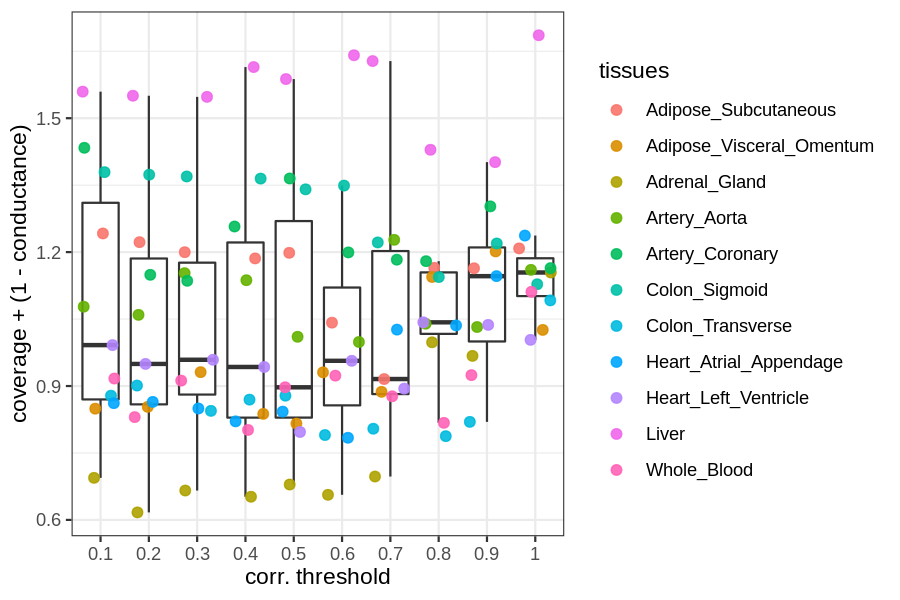

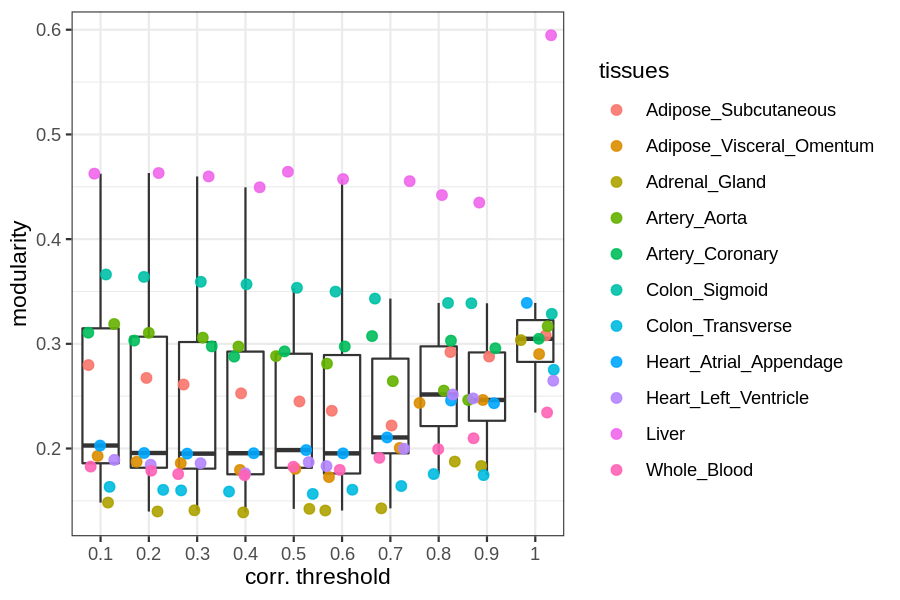

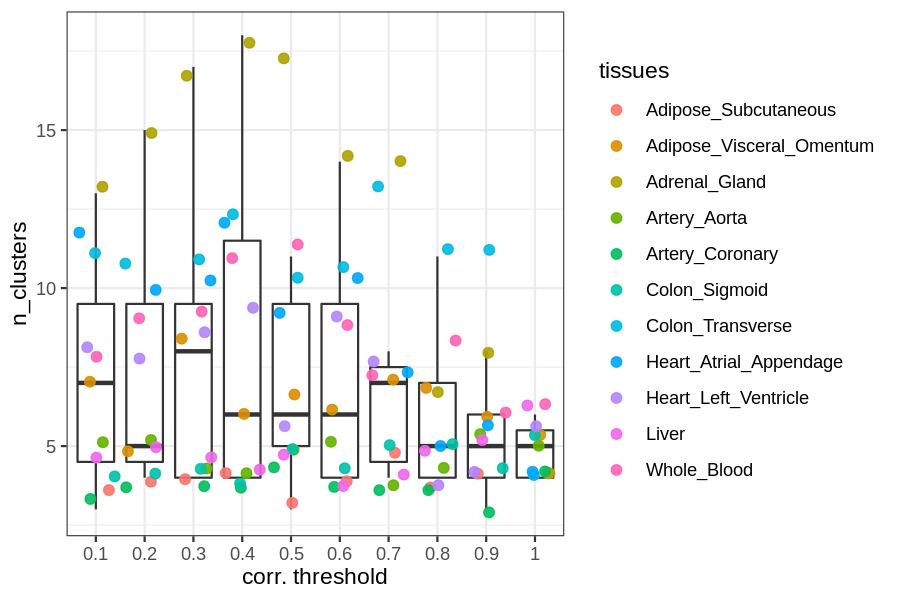

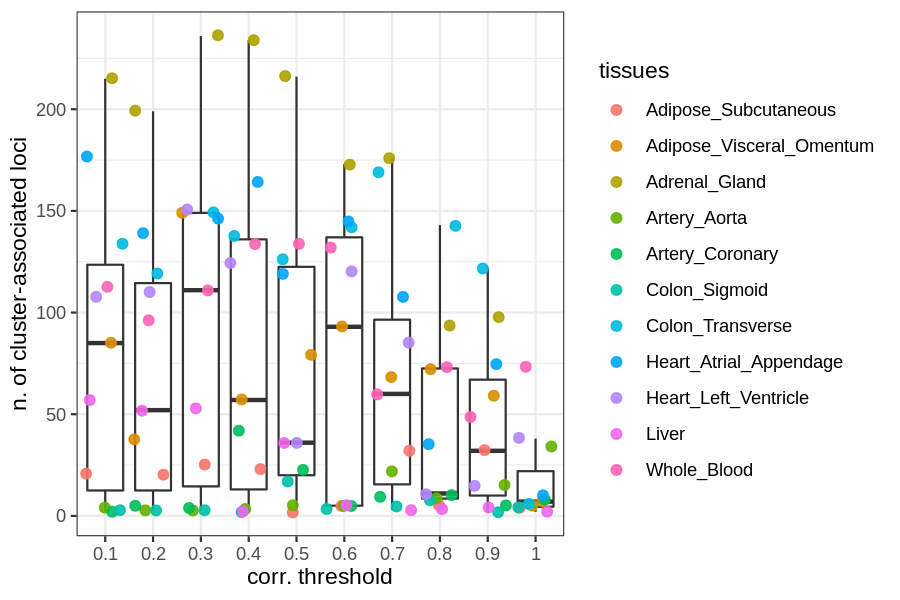

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 150)

var_names <- c("coverage_and_conductance", "modularity", "n_clusters", "n_loci")

# for(var_name in colnames(cl_eval)[2:(ncol(cl_eval) - 1)]){
for(var_name in var_names){
    if(var_name == "coverage_and_conductance"){
        y_title <- c("coverage + (1 - conductance)")
    }else{
        if(var_name == "n_loci"){
            y_title <- c("n. of cluster-associated loci")
        }else{
            y_title <- var_name
    }
    }
    pl <- ggplot(cl_eval, aes(x = as.factor(corr_thr), y = get(var_name))) + 
       geom_boxplot(outlier.shape = NA) + 
       geom_jitter(aes(color=tissues), size=2, alpha=0.9) + 
       theme_bw() + 
       ylab(y_title) +
       xlab("corr. threshold")
    print(pl)
    ggsave(plot = pl, filename = sprintf("%scorrthr_cluster_%s.pdf", fold, var_name), width = 6, height = 4)
}



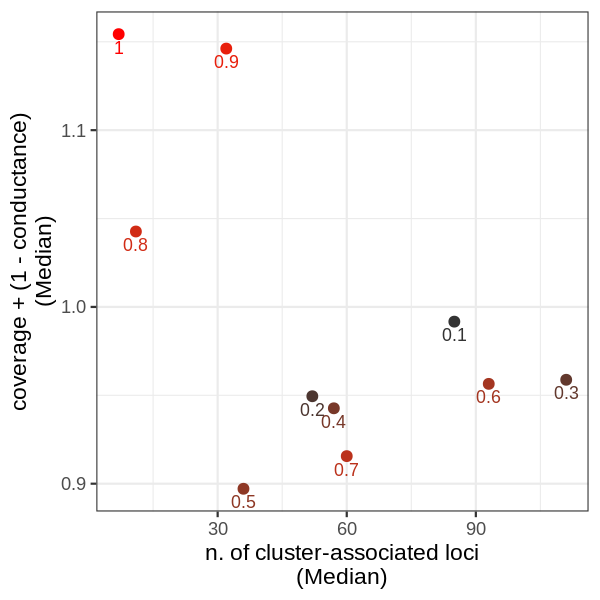

In [9]:
# plot n_loci vs cluster metrics
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 150)

summary_eval <- cl_eval %>% 
group_by(corr_thr) %>%
summarise(median_n_loci = median(n_loci), 
          median_coverage_and_conductance = median(coverage_and_conductance), 
          median_modularity = median(modularity), 
          iqr_n_loci = IQR(n_loci),
          iqr_coverage_and_conductance = IQR(coverage_and_conductance),
          iqr_modularity = IQR(modularity))

pl <- ggplot(summary_eval, 
       aes(x = median_n_loci, y = median_coverage_and_conductance, color = corr_thr)) + 
       geom_point(size = 2) +
       geom_text(aes(label = as.character(corr_thr)), size = 3, vjust = 1.5) +
       theme_bw() +
       theme(legend.position = "none") +
       scale_color_gradient(low = "grey20", high = "red") + 
       ylab("coverage + (1 - conductance)\n(Median)") +
       xlab("n. of cluster-associated loci\n(Median)")
print(pl)
ggsave(plot = pl, filename = sprintf("%scorrthr_clusterperf_vs_nloci.pdf", fold), width = 4, height = 4)


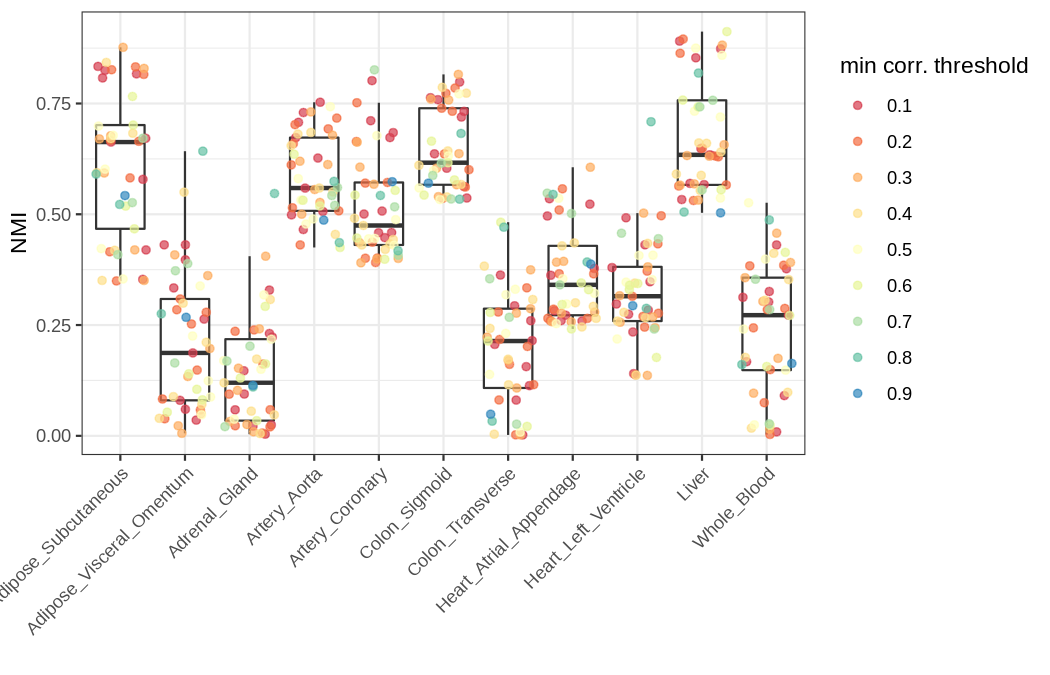

In [10]:
# plot NMI distributions
options(repr.plot.width = 7, repr.plot.height = 4.5, repr.plot.res = 150)

NMI_df <- lapply(1:length(NMI_t), function(i) 
    data.frame(stringsAsFactors = F, 
    NMI = NMI_t[[i]][lower.tri(x = NMI_t[[i]], diag = F)], 
    tissue = names(NMI_t)[i], 
    min_corr = unlist(lapply(1:length(corr_thr_list), function(y) rep(corr_thr_list[y],length(corr_thr_list) - y)))))
NMI_df <- do.call(rbind, NMI_df) %>% 
mutate(min_corr = factor(min_corr, levels = corr_thr_list))
                 
pl <- ggplot(NMI_df, aes(x = as.factor(tissue), y = NMI)) + 
       geom_boxplot(outlier.shape = NA) + 
       geom_jitter(aes(color = min_corr), alpha = 0.7) +
       theme_bw() + 
       theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
       xlab("") +
       scale_color_brewer(name = "min corr. threshold", palette = "Spectral")
pl
ggsave(plot = pl, filename = sprintf("%scorrthr_cluster_pairwiseNMI.pdf", fold), width = 7, height = 4.5)        


## Conclusion:
- best coverage + (1 - conductance) and modularity for corr thr >= 0.8
- The number of clusters is less variable for corr thr >= 0.8
- The number of loci with significant genes (corr p <= 0.05, kruskal test, merged based on position) is best for 0.9, among the 3 best corr thr. This means that 0.9 is more hetereogeneous in terms of clustering strucutre.
- NMI varies across tissues, depending on cluster quality (AS and L have the highest coverage + (1 - conductance))

Chosen corr thr: 0.9